# Benchmarking model-based design of experiment approaches with a pharmaceutical crystallisation emulator

**Installing the packages**

In [1]:
from obsidian import Campaign, ParamSpace, Target
from obsidian.parameters import Param_Categorical, Param_Ordinal, Param_Continuous, Param_Discrete
import pandas as pd
import io
import numpy as np
from pymoo.indicators.hv import HV
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error
from joblib import load
from joblib import dump

**Define parameters and targets for optimisation**

In [2]:
params = [
    Param_Continuous('Initial_temperature', 34, 40),
    Param_Continuous('Seed_load', 0, 2.625),
    Param_Ordinal('Seed_mean', ['46.94', '55.94']),
    Param_Continuous('Final_temperature', 10, 25),
    Param_Continuous('Cooling_rate', 0.1, 0.5),
    Param_Continuous('AS_end_frac', 0.45, 0.9),
    Param_Continuous('AS_rate_mL_min', 3, 10)
    ]

param_column_names = [p.name for p in params]

X_space = ParamSpace(params)

target = [
    Target('d90', aim='min'),
    Target('Yield', aim='max'),
]

target_column_names = [t.name for t in target]

campaign = Campaign(X_space, target)

**Loading the simulated data**

In [3]:
def load_data():
    # Read the dataset from the Excel file
    data = pd.read_excel(r"I:\Science\SIPBS\cmac\Thomas Pickles\SDL\lovastatin_gFP_GSA.xlsx")
    return data

**Random forest model**

This is specific to the optimisation problem and therefore needs to be run whenever inputs and outputs are changed.

In [4]:
def preprocess_data(data):
    input_features = param_column_names
    output_features = target_column_names

    X = data[input_features].values
    y = data[output_features].values

    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

    scaler = StandardScaler()
    X_train = scaler.fit_transform(X_train)
    X_test = scaler.transform(X_test)

    return X_train, X_test, y_train, y_test, scaler

def build_model():
    model = RandomForestRegressor(n_estimators=100, random_state=42)
    return model

def main():
    data = load_data()
    X_train, X_test, y_train, y_test, scaler = preprocess_data(data)

    model = build_model()
    model.fit(X_train, y_train)

    y_pred = model.predict(X_test)
    mse = mean_squared_error(y_test, y_pred)
    mae = mean_absolute_error(y_test, y_pred)
    print(f"Test MSE: {mse}, Test MAE: {mae}")

    return model, scaler

if __name__ == "__main__":
    model, scaler = main()
    dump(model, 'model.joblib')
    dump(scaler, 'scaler.joblib')

Test MSE: 2.70736632921691, Test MAE: 1.047529776622861


**Model-based design of experiment - Bayesian optimisation**

In [5]:
Z0_list = []

num_exp_list = [5, 10, 15, 20]
design_methods = ['LHS', 'Random', 'Sobol']
acquisition_functions = ['Mean', 'RS', 'SF', 'EHVI', 'NEHVI', 'NParEGO']

model = load('model.joblib')
scaler = load('scaler.joblib')


for num_exp in num_exp_list:
    for design_method in design_methods:
        # Initial Screening
        X0 = campaign.designer.initialize(num_exp, design_method)

        new_X = X0[param_column_names].values
        new_X_scaled = scaler.transform(new_X)

        predictions = model.predict(new_X_scaled)
        predictions_df = pd.DataFrame(predictions, columns=target_column_names, index=X0.index)

        Z0_initial = pd.concat([X0, predictions_df], axis=1)
        Z0_initial['Method'] = design_method

        # BO initialisation
        X0 = Z0_initial[param_column_names]
        Y0 = Z0_initial[target_column_names]

        normalized_Y0 = (Y0 - Y0.min()) / (Y0.max() - Y0.min())
        normalized_Z0 = pd.concat([X0, normalized_Y0], axis=1)
        
        campaign.add_data(normalized_Z0)
        campaign.fit()

        for acquisition_function in acquisition_functions:
            Z0 = Z0_initial.copy()

            for _ in range(5):
                X_suggest, eval_suggest = campaign.suggest(acquisition=[acquisition_function])

                new_X = X_suggest[param_column_names].values
                new_X_scaled = scaler.transform(new_X)
                predictions = model.predict(new_X_scaled)
                predictions_df = pd.DataFrame(predictions, columns=target_column_names, index=X_suggest.index)

                new_rows = pd.concat([X_suggest, predictions_df], axis=1)
                new_rows['Method'] = acquisition_function

                Z0 = pd.concat([Z0, new_rows], axis=0)

                X_new = new_rows[param_column_names]
                Y_new = new_rows[target_column_names]
                normalized_Y_new = (Y_new - Y0.min()) / (Y0.max() - Y0.min())  # normalize using original Y0 stats
                normalized_Z_new = pd.concat([X_new, normalized_Y_new], axis=1)

                campaign.add_data(normalized_Z_new)
                campaign.fit()

            Z0_list.append(Z0)


GP model has been fit to data with an R2-train-score of: 1 for response: d90
GP model has been fit to data with an R2-train-score of: 1 for response: Yield
GP model has been fit to data with an R2-train-score of: 1 for response: d90
GP model has been fit to data with an R2-train-score of: 1 for response: Yield
GP model has been fit to data with an R2-train-score of: 1 for response: d90
GP model has been fit to data with an R2-train-score of: 1 for response: Yield
GP model has been fit to data with an R2-train-score of: 1 for response: d90
GP model has been fit to data with an R2-train-score of: 1 for response: Yield
GP model has been fit to data with an R2-train-score of: 1 for response: d90
GP model has been fit to data with an R2-train-score of: 1 for response: Yield
GP model has been fit to data with an R2-train-score of: 1 for response: d90
GP model has been fit to data with an R2-train-score of: 1 for response: Yield
GP model has been fit to data with an R2-train-score of: 1 for r

C:\Users\pxb20160\AppData\Local\anaconda3v2\Lib\site-packages\linear_operator\utils\cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-08 to the diagonal
  warnings.warn(
C:\Users\pxb20160\AppData\Local\anaconda3v2\Lib\site-packages\linear_operator\utils\cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-07 to the diagonal
  warnings.warn(
C:\Users\pxb20160\AppData\Local\anaconda3v2\Lib\site-packages\linear_operator\utils\cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-06 to the diagonal
  warnings.warn(
C:\Users\pxb20160\AppData\Local\anaconda3v2\Lib\site-packages\linear_operator\utils\cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-05 to the diagonal
  warnings.warn(
C:\Users\pxb20160\AppData\Local\anaconda3v2\Lib\site-packages\linear_operator\utils\cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-04 to the diagonal
  warnings.warn(
C:\Users\pxb20160\AppData\Local\anaconda3v2\Lib\site-packages\lin

GP model has been fit to data with an R2-train-score of: 1 for response: Yield
GP model has been fit to data with an R2-train-score of: 0.976 for response: d90
GP model has been fit to data with an R2-train-score of: 1 for response: Yield
GP model has been fit to data with an R2-train-score of: 0.975 for response: d90
GP model has been fit to data with an R2-train-score of: 1 for response: Yield
GP model has been fit to data with an R2-train-score of: 0.975 for response: d90
GP model has been fit to data with an R2-train-score of: 1 for response: Yield
GP model has been fit to data with an R2-train-score of: 0.975 for response: d90
GP model has been fit to data with an R2-train-score of: 1 for response: Yield
GP model has been fit to data with an R2-train-score of: 0.975 for response: d90
GP model has been fit to data with an R2-train-score of: 1 for response: Yield
GP model has been fit to data with an R2-train-score of: 0.975 for response: d90
GP model has been fit to data with an R2

C:\Users\pxb20160\AppData\Local\anaconda3v2\Lib\site-packages\botorch\optim\optimize.py:564: RuntimeWarning: Optimization failed in `gen_candidates_scipy` with the following warning(s):
[OptimizationWarning('Optimization failed within `scipy.optimize.minimize` with status 2 and message ABNORMAL_TERMINATION_IN_LNSRCH.')]
Trying again with a new set of initial conditions.
  return _optimize_acqf_batch(opt_inputs=opt_inputs)
C:\Users\pxb20160\AppData\Local\anaconda3v2\Lib\site-packages\botorch\optim\optimize.py:564: RuntimeWarning: Optimization failed on the second try, after generating a new set of initial conditions.
  return _optimize_acqf_batch(opt_inputs=opt_inputs)


GP model has been fit to data with an R2-train-score of: 0.976 for response: d90
GP model has been fit to data with an R2-train-score of: 1 for response: Yield
GP model has been fit to data with an R2-train-score of: 0.977 for response: d90
GP model has been fit to data with an R2-train-score of: 1 for response: Yield
GP model has been fit to data with an R2-train-score of: 0.977 for response: d90
GP model has been fit to data with an R2-train-score of: 1 for response: Yield
GP model has been fit to data with an R2-train-score of: 0.977 for response: d90
GP model has been fit to data with an R2-train-score of: 1 for response: Yield
GP model has been fit to data with an R2-train-score of: 0.977 for response: d90
GP model has been fit to data with an R2-train-score of: 1 for response: Yield
GP model has been fit to data with an R2-train-score of: 0.976 for response: d90
GP model has been fit to data with an R2-train-score of: 1 for response: Yield
GP model has been fit to data with an R2

C:\Users\pxb20160\AppData\Local\anaconda3v2\Lib\site-packages\linear_operator\utils\cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-08 to the diagonal
  warnings.warn(
C:\Users\pxb20160\AppData\Local\anaconda3v2\Lib\site-packages\linear_operator\utils\cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-07 to the diagonal
  warnings.warn(
C:\Users\pxb20160\AppData\Local\anaconda3v2\Lib\site-packages\linear_operator\utils\cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-06 to the diagonal
  warnings.warn(
C:\Users\pxb20160\AppData\Local\anaconda3v2\Lib\site-packages\linear_operator\utils\cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-05 to the diagonal
  warnings.warn(
C:\Users\pxb20160\AppData\Local\anaconda3v2\Lib\site-packages\linear_operator\utils\cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-04 to the diagonal
  warnings.warn(
C:\Users\pxb20160\AppData\Local\anaconda3v2\Lib\site-packages\lin

GP model has been fit to data with an R2-train-score of: 1 for response: Yield
GP model has been fit to data with an R2-train-score of: 0.966 for response: d90
GP model has been fit to data with an R2-train-score of: 1 for response: Yield
GP model has been fit to data with an R2-train-score of: 0.966 for response: d90
GP model has been fit to data with an R2-train-score of: 1 for response: Yield
GP model has been fit to data with an R2-train-score of: 0.966 for response: d90
GP model has been fit to data with an R2-train-score of: 1 for response: Yield
GP model has been fit to data with an R2-train-score of: 0.965 for response: d90
GP model has been fit to data with an R2-train-score of: 1 for response: Yield
GP model has been fit to data with an R2-train-score of: 0.966 for response: d90
GP model has been fit to data with an R2-train-score of: 1 for response: Yield
GP model has been fit to data with an R2-train-score of: 0.966 for response: d90
GP model has been fit to data with an R2

C:\Users\pxb20160\AppData\Local\anaconda3v2\Lib\site-packages\linear_operator\utils\cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-08 to the diagonal
  warnings.warn(
C:\Users\pxb20160\AppData\Local\anaconda3v2\Lib\site-packages\linear_operator\utils\cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-07 to the diagonal
  warnings.warn(
C:\Users\pxb20160\AppData\Local\anaconda3v2\Lib\site-packages\linear_operator\utils\cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-06 to the diagonal
  warnings.warn(
C:\Users\pxb20160\AppData\Local\anaconda3v2\Lib\site-packages\linear_operator\utils\cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-05 to the diagonal
  warnings.warn(
C:\Users\pxb20160\AppData\Local\anaconda3v2\Lib\site-packages\linear_operator\utils\cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-04 to the diagonal
  warnings.warn(
C:\Users\pxb20160\AppData\Local\anaconda3v2\Lib\site-packages\lin

GP model has been fit to data with an R2-train-score of: 1 for response: Yield
GP model has been fit to data with an R2-train-score of: 0.967 for response: d90
GP model has been fit to data with an R2-train-score of: 1 for response: Yield
GP model has been fit to data with an R2-train-score of: 0.967 for response: d90
GP model has been fit to data with an R2-train-score of: 1 for response: Yield
GP model has been fit to data with an R2-train-score of: 0.967 for response: d90
GP model has been fit to data with an R2-train-score of: 1 for response: Yield
GP model has been fit to data with an R2-train-score of: 0.967 for response: d90
GP model has been fit to data with an R2-train-score of: 1 for response: Yield
GP model has been fit to data with an R2-train-score of: 0.967 for response: d90
GP model has been fit to data with an R2-train-score of: 1 for response: Yield
GP model has been fit to data with an R2-train-score of: 0.967 for response: d90
GP model has been fit to data with an R2

In [6]:
Z0_list[71]

,Initial_temperature,Seed_load,Seed_mean,Final_temperature,Cooling_rate,AS_end_frac,AS_rate_mL_min,d90,Yield,Method
0,35.093945,1.353894,55.94,21.418427,0.140832,0.643533,8.411758,146.089986,91.022600,Sobol
1,37.286633,0.684544,46.94,11.656175,0.322210,0.710433,5.964086,142.904591,87.735671,Sobol
2,39.388577,2.526554,55.94,20.117607,0.434281,0.806839,7.692301,166.974901,88.743942,Sobol
3,35.675751,0.499122,46.94,16.690746,0.202976,0.536472,3.057075,139.615032,96.337060,Sobol
4,36.672997,2.060981,46.94,15.488294,0.281844,0.605451,6.531296,150.999505,93.209075,Sobol
5,38.889118,0.145706,55.94,17.688276,0.450722,0.735412,4.111902,142.422334,79.601737,Sobol
6,38.342651,1.913070,46.94,13.037971,0.393264,0.895538,9.544317,163.151200,92.945435,Sobol
7,34.653259,1.275127,55.94,23.902561,0.174459,0.462793,4.937263,146.379306,96.577549,Sobol
8,34.282478,2.336503,46.94,19.141594,0.346240,0.515423,6.949480,147.302522,96.620276,Sobol
9,38.092354,0.380288,55.94,13.901997,0.114850,0.842039,4.585600,145.599356,83.757033,Sobol


**Hypervolume metric**

In [7]:
for Z0 in Z0_list:

    Y0 = Z0[target_column_names]

    #This is manual upper and lower bounds for d90 and yield
    new_rows = pd.DataFrame([
        [78, 17],
        [174, 99]
    ], columns=target_column_names)

    Y0 = pd.concat([Y0, new_rows], ignore_index=True)
    
    normalized_Y0 = (Y0 - Y0.min()) / (Y0.max() - Y0.min())

    normalized_Y0 = normalized_Y0.iloc[:-2]
    
    for t in target:
        if t.aim == 'max':
            normalized_Y0[t.name] = -normalized_Y0[t.name]  # Invert so we minimize all
    
    solutions = normalized_Y0.to_numpy()
    
    reference_point = [1.1 if t.aim == 'min' else -0.1 for t in target]
    
    hv = HV(ref_point=reference_point)
    
    hypervolume_values = []
    for i in range(1, len(solutions) + 1):
        subset = solutions[:i]
        hypervolume_values.append(hv.do(subset))
    
    Z0['Hypervolume'] = hypervolume_values

In [8]:
Z0_list[4]

,Initial_temperature,Seed_load,Seed_mean,Final_temperature,Cooling_rate,AS_end_frac,AS_rate_mL_min,d90,Yield,Method,Hypervolume
0,35.800000,1.837500,46.94,23.500000,0.220000,0.585000,9.300000,148.461125,92.029770,LHS,0.298313
1,37.000000,1.312500,46.94,14.500000,0.460000,0.495000,5.100000,152.642131,96.965960,LHS,0.317726
2,39.400000,0.787500,55.94,11.500000,0.140000,0.675000,7.900000,166.516162,91.170060,LHS,0.317726
3,38.200000,2.362500,55.94,20.500000,0.380000,0.855000,6.500000,158.550633,84.867497,LHS,0.317726
4,34.600000,0.262500,55.94,17.500000,0.300000,0.765000,3.700000,129.178102,79.334330,LHS,0.450332
0,37.000607,0.400190,55.94,19.117603,0.258169,0.471908,3.000000,143.813729,96.082226,NEHVI,0.462371
0,34.000000,0.000000,55.94,15.898853,0.295208,0.543787,4.774095,134.427600,96.356114,NEHVI,0.482974
0,34.222434,0.000000,55.94,14.783311,0.386174,0.530003,3.000000,134.581296,96.511895,NEHVI,0.483332
0,34.475599,0.014158,55.94,17.073114,0.312364,0.620130,3.344044,134.000713,89.137855,NEHVI,0.483863
0,34.000000,0.650719,55.94,13.688209,0.298801,0.483599,3.975273,139.353450,97.818534,NEHVI,0.489422


**Saving the data as csv files**

In [9]:
for i, df in enumerate(Z0_list):
    first_method = df['Method'].iloc[0]
    last_method = df['Method'].iloc[-1]
    exp = len(df) - 5

    filename = f"df_{exp}_{first_method}_{last_method}_campaign5.csv"
    df.to_csv(filename, index=False)

**Figures**

In [15]:
df = Z0_list[71]
df

,Initial_temperature,Seed_load,Seed_mean,Final_temperature,Cooling_rate,AS_end_frac,AS_rate_mL_min,d90,Yield,Method,Hypervolume
0,35.093945,1.353894,55.94,21.418427,0.140832,0.643533,8.411758,146.089986,91.022600,Sobol,0.313644
1,37.286633,0.684544,46.94,11.656175,0.322210,0.710433,5.964086,142.904591,87.735671,Sobol,0.338949
2,39.388577,2.526554,55.94,20.117607,0.434281,0.806839,7.692301,166.974901,88.743942,Sobol,0.338949
3,35.675751,0.499122,46.94,16.690746,0.202976,0.536472,3.057075,139.615032,96.337060,Sobol,0.397480
4,36.672997,2.060981,46.94,15.488294,0.281844,0.605451,6.531296,150.999505,93.209075,Sobol,0.397480
5,38.889118,0.145706,55.94,17.688276,0.450722,0.735412,4.111902,142.422334,79.601737,Sobol,0.397480
6,38.342651,1.913070,46.94,13.037971,0.393264,0.895538,9.544317,163.151200,92.945435,Sobol,0.397480
7,34.653259,1.275127,55.94,23.902561,0.174459,0.462793,4.937263,146.379306,96.577549,Sobol,0.398617
8,34.282478,2.336503,46.94,19.141594,0.346240,0.515423,6.949480,147.302522,96.620276,Sobol,0.398814
9,38.092354,0.380288,55.94,13.901997,0.114850,0.842039,4.585600,145.599356,83.757033,Sobol,0.398814


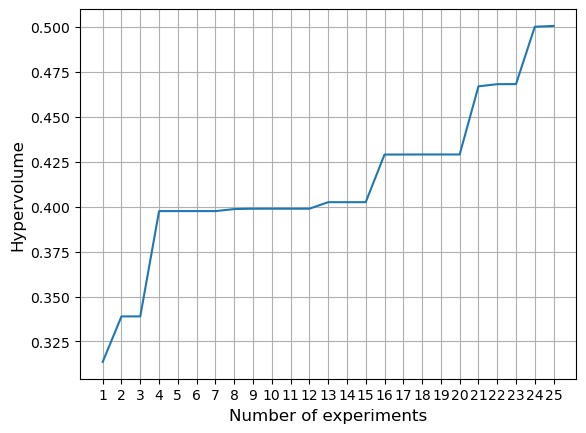

In [16]:
x = np.arange(1, len(df) + 1)
y = df[["Hypervolume"]].to_numpy().ravel()
plt.plot(x, y)
plt.ylabel("Hypervolume", fontsize=12)
plt.xlabel("Number of experiments", fontsize=12)
plt.xticks(x)
plt.grid(True)
plt.show()